In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv(
    "construction_features_timeseries.csv",
    parse_dates=["Date"]
)

df.sort_values(["Project_ID", "Date"], inplace=True)

project_id = df["Project_ID"].iloc[0]
proj_df = df[df["Project_ID"] == project_id].set_index("Date")

proj_df.head()


,Project_ID,Planned_Cost,Actual_Cost,Planned_Progress,Actual_Progress,Vibration_Level,Crack_Width,Temperature,Humidity,Labor_Hours,...,Labor_Hours_lag2,Cost_rolling_3,Progress_rolling_3,Cost_Deviation,Progress_Delay,Cost_per_LaborHour,Cost_per_Equipment,High_Cost_Overrun_Flag,High_Progress_Delay_Flag,Risk_Level_Encoded
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-19,PJT_1,275523.235955,3.626207e+05,2.247191,1.110690,1.453852,2.814901,18.024173,40.071256,67.091582,...,69.805903,2083.054318,-2.333298,87097.447593,1.136501,5325.484754,4668.222231,0,0,2
2020-01-26,PJT_1,413284.853933,5.791478e+05,3.370787,3.294323,1.533286,2.851868,17.916870,54.675666,69.561126,...,80.584834,330962.667409,-1.009267,165862.972445,0.076464,8207.746424,7318.914390,0,0,2
2020-02-02,PJT_1,551046.471910,9.896604e+05,4.494382,1.397148,1.349615,2.827027,21.440585,48.549559,59.099356,...,67.091582,643809.651346,1.934054,438613.972204,3.097234,16467.072419,13553.764934,0,1,2
2020-02-09,PJT_1,688808.089888,5.985079e+05,5.617978,6.089291,1.545437,2.731789,20.602878,64.766640,78.584778,...,69.561126,722438.721091,3.593587,-90300.197104,-0.471313,7520.381475,7830.375585,0,0,2
2020-02-16,PJT_1,826569.707865,1.287894e+06,6.741573,1.675068,1.700409,2.826256,20.961353,58.843743,74.707599,...,59.099356,958687.373153,3.053836,461324.074696,5.066505,17011.420209,16825.369158,0,1,2


In [3]:
data = proj_df[["Actual_Cost"]].values


In [4]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [5]:
def create_sequences(data, window_size=5):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW_SIZE = 5
X, y = create_sequences(data_scaled, WINDOW_SIZE)

X.shape, y.shape


((83, 5), (83,))

In [6]:
X = X.reshape((X.shape[0], X.shape[1], 1))
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [7]:
model = Sequential([
    LSTM(64, activation="tanh", input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


C:\Users\Jina\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - loss: 0.2036 - val_loss: 0.5875
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1499 - val_loss: 0.4447
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1065 - val_loss: 0.3229
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0718 - val_loss: 0.2184
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0421 - val_loss: 0.1288
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0202 - val_loss: 0.0579
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0090 - val_loss: 0.0147
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0088 - val_loss: 0.0016
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0125 - val_loss: 8.1184e-04
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0111 - val_loss: 0.0034
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0074 - val_loss: 0.0108
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0054 -

In [9]:
y_pred_scaled = model.predict(X_test)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


In [10]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print("LSTM MAE:", mae)
print("LSTM RMSE:", rmse)


LSTM MAE: 943405.7285418945
LSTM RMSE: 1013576.390565332


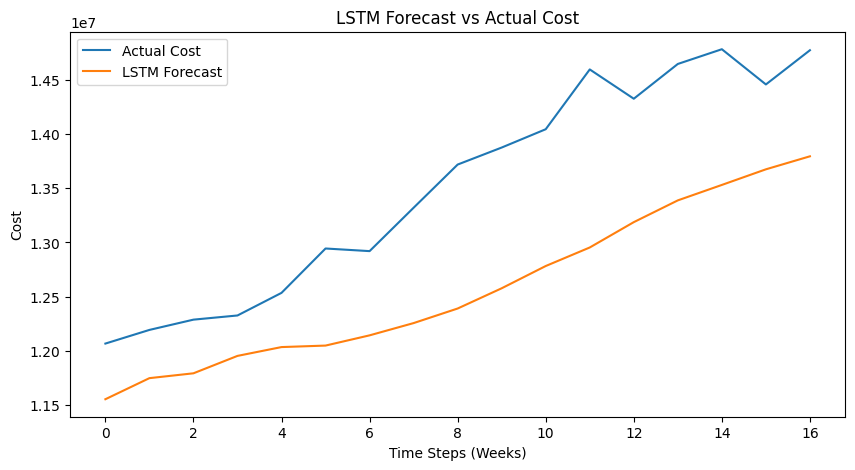

In [11]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Actual Cost")
plt.plot(y_pred_inv, label="LSTM Forecast")
plt.title("LSTM Forecast vs Actual Cost")
plt.xlabel("Time Steps (Weeks)")
plt.ylabel("Cost")
plt.legend()
plt.show()
